## SENTIMENT PREDICTION (POSITIVE/NEGATIVE) FOR CUSTOMER COMMENT SENTENCE

In this notebook, you will:

    Part 1: Load the IMDB dataset
    Part 2: Load a BERT model from TensorFlow Hub
    Part 3: Build your own model by combining BERT with a classifier
    Part 4: Train your own model, fine-tuning BERT as part of that
    Part 5: Save your model and use it to classify sentences

    IMPORTANT NOTE:
    The train time in this DEMO is long. It takes about 80minutes/epoch. So currently I set epochs = 1 for quickest in training.
    Google Colab will auto interupt each 90 minutes if you do not interact with colab screen. 
    Please keep click or roll in colab runing page every 90 min if you do not want everything be zero.
    

**Part 0: Install the required library**

In [4]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text


     |████████████████████████████████| 4.4 MB 1.3 MB/s 


In [5]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 8.1 MB/s 
     |████████████████████████████████| 636 kB 48.5 MB/s 
     |████████████████████████████████| 1.1 MB 47.3 MB/s 
     |████████████████████████████████| 352 kB 72.9 MB/s 
     |████████████████████████████████| 90 kB 11.1 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 1.2 MB 54.8 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 213 kB 70.2 MB/s 


In [6]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

**Part 1: Load the IMDB dataset**

Load the IMDB dataset. This is the sentiment movie dataset which includes customer comment for movie and label is positive or negative

The dataset include train and test data

In [7]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 1s 0us/step


In [8]:
# train, valid, test data preparation

AUTOTUNE = tf.data.AUTOTUNE  # track time spend in pipeline, optimized resource for optimized time
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [9]:
# show you how train data look like.

for text_batch, label_batch in train_ds.take(1):
  for i in range(10):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [10]:
train_ds

<PrefetchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

NOTE: train_ds data is MultiHead Attention (this is used for context learning, multisentence learning)

**Part 2: Load a BERT model from TensorFlow Hub**

There are various pre-trained BERT models which are available in Tensorflow Hub.

The below is the path to them. Just get the pre-trained BERT weight of architecture which you want and use.

In [11]:
# Choosing the BERT Model

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

# L-4 H-512 A-8 mean
# L=4: Transformer Block (Layers): 4 layers
# H=512: a hidden size (mean 512 LSTM nodes, 512/4 = 128 LSTM nodes/Layer)
# A=8 attention heads. Multi sentence input --> multitoken input (8 token input???)
# H = 512, the number of embedded features for each sentence

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [12]:
# Preprocessing model
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [13]:
# input sentence and token conversion
# JUST 1 sentence to see
text_test = ['this is such an amazing movie!']
#text_test = ['this is such an amazing movie is not !']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

# Question: Why 12??? --> just for display
#           why shape is (1,128) but length of words ids only 12????  --> total is 128, mean sentence with 128 words, but just get 12 for display
# text_preprocessed: dictionary

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
# shape of input_word_ids: 128 (means input of LSTM is 128 words, the sentence length up to 128 words)
len(text_preprocessed["input_word_ids"][0])

128

In [15]:
# Using BERT Model
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [16]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

# L-4 H-512 A-8 mean
# L = Transformation Block (Layers): 4 layers
# H = is hidden layer (512), also is length of embedded features (512) will be returned by BERT (this is of first LSTM block (512 LSTM node))

# key of bert results: dict_keys(['encoder_outputs', 'sequence_output', 'default', 'pooled_output'])

# "pooled_output" has shape (1, 512): give embedded length 512 for whole sentence.
# "sequence_output" has shape (1,128,512): give embedded of 128 words in sentence, each word has its embedded vector of 512.
# 
# 'default' is 'pooled_output' (default and pooled_output is same this case)

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626293   0.9928098  -0.18611859  0.36673865  0.15233742  0.6550452
  0.9681154  -0.94862705  0.00216148 -0.9877732   0.0684269  -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321287  0.33231482 ...  0.21300784  0.7102064
  -0.05771124]
 [-0.28742093  0.3198104  -0.2301862  ...  0.58455014 -0.21329764
   0.7269209 ]
 [-0.6615701   0.6887682  -0.8743294  ...  0.10877228 -0.26173192
   0.4785537 ]
 ...
 [-0.22561091 -0.28925657 -0.07064448 ...  0.47566032  0.8327713
   0.40025362]
 [-0.298242   -0.27473173 -0.05450522 ...  0.48849788  1.0955355
   0.18163413]
 [-0.44378197  0.00930735  0.07223716 ...  0.172901    1.1833245
   0.07898018]]


In [21]:
print(bert_results.keys()

dict_keys(['sequence_output', 'default', 'pooled_output', 'encoder_outputs'])

In [17]:
len(bert_results["pooled_output"][0])

512

In [18]:
bert_results["pooled_output"][0][:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.7626293 ,  0.9928098 , -0.18611859,  0.36673865,  0.15233742,
        0.6550452 ,  0.9681154 , -0.94862705,  0.00216148, -0.9877732 ],
      dtype=float32)>

In [19]:
bert_results["sequence_output"][0][3][:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.0419872 , -0.2394518 , -1.3191537 , -0.586867  , -0.90046847,
        1.2352037 , -0.31788552, -0.12824872,  0.11661758,  2.2037194 ],
      dtype=float32)>

In [20]:
bert_results["default"][0][:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.7626293 ,  0.9928098 , -0.18611859,  0.36673865,  0.15233742,
        0.6550452 ,  0.9681154 , -0.94862705,  0.00216148, -0.9877732 ],
      dtype=float32)>

**Part 3: Build your own model by combining BERT with a classifier**

Define your BERT architect which is equivalent with the using model weight.

In [39]:
# Define structure of Fine-Tuning Model

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')            # 1-Input layer
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')   # 2-Processing Keras Layer
  encoder_inputs = preprocessing_layer(text_input)                                           # connect  
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')   # 3-BERT encoder Keras Layer
  outputs = encoder(encoder_inputs)                                                        # connect
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)                                               # 4-Dropout
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)               # 5-Classifier Dense: logistic regression
  return tf.keras.Model(text_input, net)

In [40]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.constant(text_test))
print(bert_raw_result)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([b'this is such an amazing movie!'], shape=(1,), dtype=string)
tf.Tensor([[0.1673257]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.5417341]], shape=(1, 1), dtype=float32)


In [41]:
# Define loss function and metrics for evaluation
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [42]:
# Optimizer
epochs = 1 #5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()  # remove .take(100), I change for quick train
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 6e-5 #3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [43]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [44]:
bert_model_savefolder = '/content/drive/MyDrive/Colab Notebooks/BERT_model_savefolder'
#classifier_model = tf.saved_model.load(bert_model_savefolder)

**Part 4: Train your own model, fine-tuning BERT as part of that**

Train the pre-trained BERT with train and valid dataset (take time about 80 minutes per epoch)

After model is trained, check its accuracy with test data. Accuracy: 0.856


In [45]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
625/625 [==============================] - 4663s 7s/step - loss: 0.4473 - binary_accuracy: 0.7749 - val_loss: 0.3578 - val_binary_accuracy: 0.8438
Epoch 2/2
625/625 [==============================] - 4638s 7s/step - loss: 0.2826 - binary_accuracy: 0.8760 - val_loss: 0.3667 - val_binary_accuracy: 0.8486


In [46]:
# Model Evaluation
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 1553s 2s/step - loss: 0.3522 - binary_accuracy: 0.8557
Loss: 0.3522106111049652
Accuracy: 0.8557199835777283


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
epochs range(1, 3)


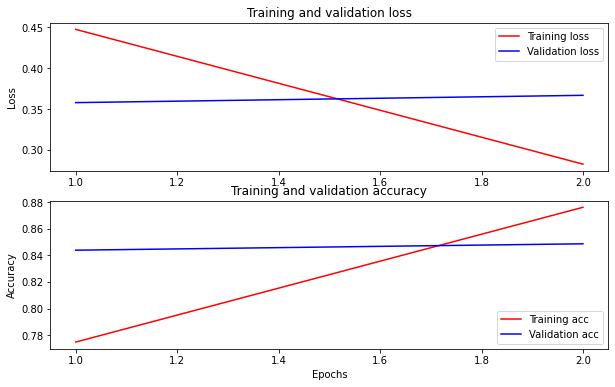

In [48]:
# this draw the loss of model by epoch train (NOT IMPORTANT)
# when set epochs = 1, the figure has only one epoch --> NO figure

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()
print('epochs',epochs)
plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Part 5: Save your model and use it to classify sentences**

Saving the model weight after training for using it when makes the prediction.

Load model and make prediction

Let's examplize some sentences as customer comment about the movie and get the prediction result of it sentiment.

In [49]:
# Export Model for Inference

dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [53]:
# Reload model to do Prediction

reloaded_model = tf.saved_model.load(saved_model_path)

In [54]:
# PREDICT THE SENTIMENT OF SENTENCES

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


# put you sentence here and try run this cell to get the result.
examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'I love the movie',
    'I do not like the movie',
    'the movie is so poor',
    'i will go to cinema again for the movie',
    'I love it',
    'Don\'t like',
    'I will watch one more time'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)


Results from the saved model:
input: this is such an amazing movie! : score: 0.998312
input: The movie was great!           : score: 0.988195
input: The movie was meh.             : score: 0.911837
input: The movie was okish.           : score: 0.080599
input: The movie was terrible...      : score: 0.001659
input: I love the movie               : score: 0.993452
input: I do not like the movie        : score: 0.226749
input: the movie is so poor           : score: 0.008110
input: i will go to cinema again for the movie : score: 0.948195
input: I love it                      : score: 0.995961
input: Don't like                     : score: 0.258900
input: I will watch one more time     : score: 0.956638



**END**